# Test on single audio

* specify the file on which to perform the prediction
* specify the pretrained model

In [12]:
from predict import main

absolute_path_to_model = '/home/stas/UnsupSeg/Trained/epoch=8.ckpt' 
path_to_audio = '/home/stas/UnsupSeg/data/felix/datasets/timit/test/timit_big_data_TEST_DR1_FAKS0_SI943.wav'
prominence = 0.15

# make prediction for chosen .wav file, but don't write file with scores and boundaries
preds_seconds, preds_pixels = main(path_to_audio, absolute_path_to_model, prominence, writefile = False)

running inference on: /home/stas/UnsupSeg/data/felix/datasets/timit/test/timit_big_data_TEST_DR1_FAKS0_SI943.wav
running inferece using ckpt: /home/stas/UnsupSeg/Trained/epoch=8.ckpt


 ------------------------------------------------------------------------------------------
learning features from raw wav
prediction steps: [1]
overriding prominence with 0.15
cpu
predicted boundaries (in seconds):
[0.18 0.21 0.69 0.72 0.79 0.82 0.93 0.97 1.12 1.3  1.42 1.54 1.58 1.68
 1.76 1.83 1.88 1.9  1.96 1.99 2.02 2.08 2.16 2.27 2.31 2.43 2.46 2.49
 2.55 2.57 2.6  2.62 2.73 2.78 2.83 2.89 2.93 2.97 3.1  3.23 3.28 3.43
 3.59]
predicted boundaries (in pixels):
[ 18  21  69  72  79  82  93  97 112 130 142 154 158 168 176 183 188 190
 196 199 202 208 216 227 231 243 246 249 255 257 260 262 273 278 283 289
 293 297 310 323 328 343 359]
predicted segments:
44


# Saving test results: phonemas, boundaries, scores (for the following clasterization)
* set write_data = True
* specify the test data folder
* specify the pretrained model

In [ ]:
import os
import h5py
from predict import main

# Create files with spectrums, boundaries and scores
write_data = True

# if yes, then create empty files
if write_data == True:
    # create file for data
    with h5py.File('Phonemas.hdf5', 'w') as f:
        f.close()
    with h5py.File('Boundaries.hdf5', 'w') as f:
        f.close()
    with h5py.File('Scores.hdf5', 'w') as f:
        f.close()

# test data and model folders
test_data = '/home/stas/UnsupSeg/data/felix/datasets/timit/test'
absolute_path_to_model = '/home/stas/UnsupSeg/Trained/epoch=8.ckpt' 
prominence = 0.15

# for each file in train data make predibtion
for root, dirs, files in os.walk(test_data):
    for file in files:
        if file.endswith('.wav'):
            corrent_wav_path = os.path.join(test_data,file)
            print(corrent_wav_path)
            preds_seconds, preds_pixels = main(corrent_wav_path, absolute_path_to_model, prominence, writefile = write_data)

# Extract data to be processed from files

In [1]:
def slice_phonemaes(phonemas, boundaries):
    phonema_sliced = []
    phonema_sliced_sum = []
    for spectrum_idx in range(len(phonemas)):
#         print('spectrum '+str(spectrum_idx+1)+' is processing')
        
        for bound_idx in range(len(boundaries[spectrum_idx])-1):
            phonema = phonemas[spectrum_idx][:,boundaries[spectrum_idx][bound_idx]:boundaries[spectrum_idx][bound_idx+1]]
            phonema_sliced.append(phonema) # full representation of phoneme
            phonema_sliced_sum.append(phonema.sum(axis = 1).reshape(64,1)) # short representation of phoneme
    return phonema_sliced, phonema_sliced_sum

def read_data():
    import h5py
    phonemas = []
    boundaries = []
    scores = []
    realbounds = []

    with h5py.File('Phonemas.hdf5', 'r') as f:
        print('phonemas file ',len(f.keys()))
        for i in range(int(len(f.keys()))):
            phonemas.append(f['phoneme_'+str(i)][:])

    with h5py.File('Boundaries.hdf5', 'r') as f:
        print('boundaries file ',len(f.keys()))
        for i in range(int(len(f.keys()))):
            boundaries.append(f['bounds_'+str(i)][:])

    with h5py.File('Scores.hdf5', 'r') as f:
        print('scores file ',len(f.keys()))
        for i in range(int(len(f.keys()))):
            scores.append(f['scores_'+str(i)][:])
            
    with h5py.File('Realbounds.hdf5', 'r') as f:
        print('realbounds file ',len(f.keys()))
        for i in range(int(len(f.keys()))):
            realbounds.append(f['real_bound_'+str(i)][:])
            
    # phonema slicing
    phonema_sliced, phonema_sliced_sum = slice_phonemaes(phonemas,boundaries)
        
    print()
    print('phonemas ',len(phonemas))
    print('boundaries ',len(boundaries))
    print('scores ',len(scores))
    print('realbounds ',len(realbounds))
    print()
    print('Phonemas detected:',len(phonema_sliced))
    return phonemas, scores, boundaries, realbounds, phonema_sliced, phonema_sliced_sum

phonemas, scores, boundaries, realbounds, phonema_sliced, phonema_sliced_sum = read_data()

phonemas file  1680
boundaries file  1680
scores file  1680
realbounds file  1680

phonemas  1680
boundaries  1680
scores  1680
realbounds  1680

Phonemas detected: 64746


# Plot example of data: spectral reprezentation, score and boundaries

1680 1680 1680
(64, 341) (32,) (340,)
[ 15.  24.  29.  35.  49.  52.  56.  61.  69.  70.  81.  87.  91.  93.
 104. 116. 119. 128. 134. 138. 142. 150. 159. 162. 170. 185. 193. 198.
 204. 216. 218. 230. 241. 247. 257. 264. 278.]
472


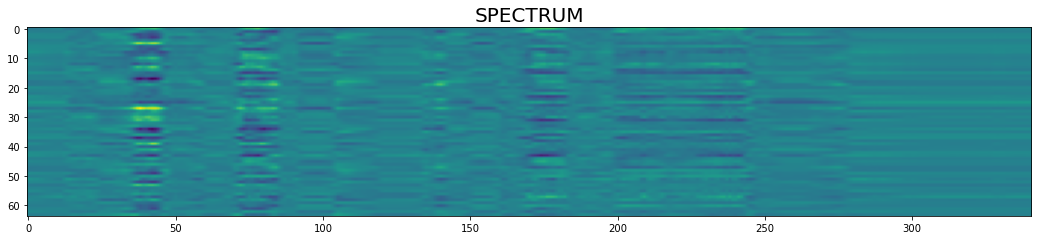

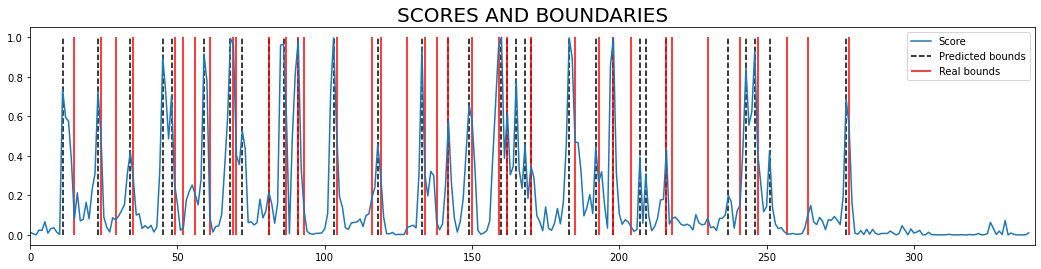

In [44]:
import numpy as np
import matplotlib.pyplot as plt

m = np.random.randint(len(phonemas))
m = 472
plt.figure(figsize=(18,4))

plt.title('SPECTRUM',fontsize = 20)
plt.imshow(phonemas[m])
plt.figure(figsize=(18,4))

plt.title('SCORES AND BOUNDARIES',fontsize = 20)
plt.plot(scores[m],label='Score')

plt.xlim([0,phonemas[m].shape[1]])
plt.vlines(boundaries[m], 0, 1, linestyles ="dashed", colors ="k",label='Predicted bounds')
plt.vlines(realbounds[m], 0, 1, linestyles ="solid", colors ="r",label='Real bounds')
plt.legend()

print(len(phonemas), len(boundaries), len(scores))
print(phonemas[m].shape, boundaries[m].shape, scores[m].shape)

print(realbounds[m])

print(m)

# Main for training and testing

* To train use ckpt: null in config.yaml
* To train use ckpt: absolute_path_to_training_data in config.yaml
* don't forget to set up folders with training data

In [ ]:
import yaml
import os
import random
import socket
from argparse import Namespace
from distutils.dir_util import copy_tree

import hydra
import numpy as np
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.backends import cudnn

from solver import Solver
torch.autograd.set_detect_anomaly(True)

import h5py

write_data = True

def main():
    
    if write_data == True:
        # create file for data
        with h5py.File('Spectrum.hdf5', 'w') as f:
            f.close()
    
    with open('config.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
        cfg = yaml.load(file, Loader=yaml.FullLoader)
    cfg = Namespace(**dict(cfg))
    
    torch.manual_seed(cfg.seed)
    np.random.seed(cfg.seed)
    random.seed(cfg.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"running in: {os.getcwd()}")
    cfg.wd = os.getcwd()
    cfg.host = socket.gethostname()
    cfg.project = "default" if not hasattr(cfg, "project") else cfg.project

    checkpoint_callback = ModelCheckpoint(
        filepath=os.getcwd(),
        save_top_k=1,
        verbose=True,
        monitor=cfg.early_stop_metric,
        mode=cfg.early_stop_mode,
        prefix='',
    )

    trainer = Trainer(
        checkpoint_callback=checkpoint_callback,
        early_stop_callback=None,
        distributed_backend="dp",
        show_progress_bar=True,
        num_sanity_val_steps=0,
        track_grad_norm=2,
        print_nan_grads=True,
        gpus=cfg.gpus,
        gradient_clip_val=cfg.grad_clip,
        val_check_interval=cfg.val_check_interval,
        fast_dev_run=cfg.dev_run,
        max_epochs=cfg.epochs
    )

    if cfg.ckpt is not None:
        ckpt = cfg.ckpt
    else:
        solver = Solver(cfg, writefile = write_data)

        print('START FITTING')
        trainer.fit(solver)
        print('END FITTING')

        ckpt = solver.get_ckpt_path()

    print(f"running test on ckpt: {ckpt}")
    print(f"testing for {cfg.data.upper()}")
    solver = Solver.load_from_checkpoint(ckpt)

    # override checkpoint paths with current conf paths
    solver.hp.timit_path = cfg.timit_path
    solver.hp.buckeye_path = cfg.buckeye_path
    solver.hp.arabic_path = cfg.arabic_path
    solver.hp.libri_path = cfg.libri_path
    
    solver.hp.data = cfg.data
    
    print('START TEST')
    trainer.test(solver)
    print('END TEST')

if __name__ == "__main__":
    main()

# TIMIT parser

In [ ]:
import os
import shutil

inpath = 'other/timit_big/data' # TIMIT in location
outpath = 'other/timit_big_parsed' # TIMIT out location
# to create "other" folder,+train, +test

def big_timit_parser(inpath, outpath):
    for root, dirs, files in os.walk(inpath):
        for file in files:
            if file.endswith('.PHN') or file.endswith('.wav'):
                src_name = "{}/{}".format(root, file)
                
                if "TEST" in src_name:
                    print(src_name)
                    fold = "test"
                    tgt_name = os.path.join(outpath,fold,src_name.replace("/", "_"))
                    if ".WAV" in tgt_name:
                        tgt_name = tgt_name.replace('.WAV', '')


                if "TRAIN" in src_name:
                    print(src_name)
                    fold = "train"
                    tgt_name = os.path.join(outpath,fold,src_name.replace("/", "_"))
                    if ".WAV" in tgt_name:
                        tgt_name = tgt_name.replace('.WAV', '')
                shutil.copy(src_name, tgt_name)

big_timit_parser(inpath, outpath)

# Data loaders testing

### Arabic datset loading

In [14]:
import numpy as np
from dataloader import TrainTestDataset

path = 'data/felix/datasets/arabic'
train, val, test = TrainTestDataset.get_datasets(path=path)

print("DATA:")
print(f"train: {path} {len(train)}")
print(f"valid: {path} {len(val)}")
print(f"test: {path} {len(test)}")

DATA:
train: data/felix/datasets/arabic 0
valid: data/felix/datasets/arabic 0
test: data/felix/datasets/arabic 1813


In [15]:
random_sample = 0
display(test[random_sample][0])
N = 15 # how much data to show
print()
print('AUDIO =    ', test[random_sample][1][:N])
print()
print('PHONEMES = ', test[random_sample][2][:N])
print()
print('LENGTH =   ', test[random_sample][3])
print()
print('PATH =    ', test[random_sample][4])

tensor([0., 0., 0.,  ..., 0., 0., 0.])


AUDIO =     [21.0, 29.0, 33.0, 43.0, 49.0, 54.0, 65.0, 71.0, 78.0, 81.0, 100.0, 104.0, 113.0, 123.0, 127.0]

PHONEMES =  ['sil', 'w', 'a', 'k', "a'", 'y', 'f', 'a', 't', 'a', 'E', "a'", 'rr', 'A', 'D']

LENGTH =    863

PATH =     data/felix/datasets/arabic/test/1000.wav


### TIMIT datset loading

In [7]:
import numpy as np
from dataloader import TrainTestDataset

path = 'data/felix/datasets/timit'
train, val, test = TrainTestDataset.get_datasets(path=path)

print("DATA:")
print(f"train: {path} {len(train)}")
print(f"valid: {path} {len(val)}")
print(f"test: {path} {len(test)}")

DATA:
train: data/felix/datasets/timit 4158
valid: data/felix/datasets/timit 462
test: data/felix/datasets/timit 1680


In [41]:
random_sample = 472
display(test[random_sample][0])
N = 20022 # how much data to show
print()
print('AUDIO =    ', test[random_sample][1][:N])
print()
print('PHONEMES = ', test[random_sample][2][:N])
print()
print('LENGTH =   ', test[random_sample][3])
print()
print('PATH =    ', test[random_sample][4])

tensor([ 2.1362e-04,  2.4414e-04, -2.1362e-04,  ...,  0.0000e+00,
        -3.0518e-05,  3.0518e-05])


AUDIO =     [15.0, 24.0, 29.0, 35.0, 49.0, 52.0, 56.0, 61.0, 69.0, 70.0, 81.0, 87.0, 91.0, 93.0, 104.0, 116.0, 119.0, 128.0, 134.0, 138.0, 142.0, 150.0, 159.0, 162.0, 170.0, 185.0, 193.0, 198.0, 204.0, 216.0, 218.0, 230.0, 241.0, 247.0, 257.0, 264.0, 278.0]

PHONEMES =  ['h#', 'sh', 'iy', 'hv', 'ae', 'dcl', 'y', 'axr', 'dcl', 'd', 'aa', 'r', 'kcl', 'k', 's', 'ux', 'q', 'en', 'gcl', 'g', 'r', 'iy', 's', 'ix', 'w', 'aa', 'sh', 'epi', 'w', 'ao', 'dx', 'axr', 'ao', 'l', 'y', 'iy', 'axr', 'h#']

LENGTH =    341

PATH =     data/felix/datasets/timit/test/timit_big_data_TEST_DR4_MJDM1_SA1.wav


## Save real bounds

In [7]:
import h5py

with h5py.File('Realbounds.hdf5', 'w') as f:
        f.close()

for num in range(len(test)):
    with h5py.File('Realbounds.hdf5', 'a') as f:
        length = len(f.keys())
        for i in range(1):
            f.create_dataset('real_bound_'+str(i + length), data = np.array(test[num][1]))
        f.close()

In [8]:
realbounds = []
with h5py.File('Realbounds.hdf5', 'r') as f:
    print('realbounds file ',len(f.keys()))
    for i in range(int(len(f.keys()))):
        realbounds.append(f['real_bound_'+str(i)][:])
len(realbounds)

realbounds file  2


2

### BUCKEYE datset loading

In [19]:
import numpy as np
from dataloader import TrainValTestDataset

path = 'data/felix/datasets/buckeye'
train, val, test = TrainValTestDataset.get_datasets(path=path)

print("DATA:")
print(f"train: {path} {len(train)}")
print(f"valid: {path} {len(val)}")
print(f"test: {path} {len(test)}")

DATA:
train: data/felix/datasets/buckeye 204
valid: data/felix/datasets/buckeye 25
test: data/felix/datasets/buckeye 25


In [20]:
random_sample = 0
display(test[random_sample][0])
N = 15 # how much data to show
print()
print('AUDIO =    ', test[random_sample][1][:N])
print()
print('PHONEMES = ', test[random_sample][2][:N])
print()
print('LENGTH =   ', test[random_sample][3])
print()
print('PATH =    ', test[random_sample][4])

tensor([-0.0009, -0.0009, -0.0007,  ...,  0.0001, -0.0003, -0.0003])


AUDIO =     [0.0, 10.0, 13.0, 17.0, 28.0, 36.0, 42.0, 45.0, 50.0, 58.0, 64.0, 68.0, 71.0, 76.0, 83.0]

PHONEMES =  ['ng', 'ih', 'th', '{B_TRANS}', 'IVER', 'ih', 'z', 'ih', 'k;', 's', 't', 'r', 'ao', 'r;', 'd;']

LENGTH =    4927

PATH =     data/felix/datasets/buckeye/test/s3201b.wav


# Outliers detecting

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

durations_real = []
for i in range(len(realbounds)):
    # next bounds - previous bounds = durations
    durations_real.extend(realbounds[i][1:] - realbounds[i][:-1])

durations_estimated = []
for i in range(len(boundaries)):
    # next bounds - previous bounds = durations
    durations_estimated.extend(boundaries[i][1:] - boundaries[i][:-1])
    
data = pd.DataFrame(data = durations_real)
data1 = pd.DataFrame(data = durations_estimated)

print('real max duration',data.max().max())
print('estim max duration',data1.max().max())
print('real min duration',data.min().min())
print('estim min duration',data1.min().min())

real max duration 90.0
estim max duration 95
real min duration 0.0
estim min duration 2


### Real phoneme durations distribution

/home/stas/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

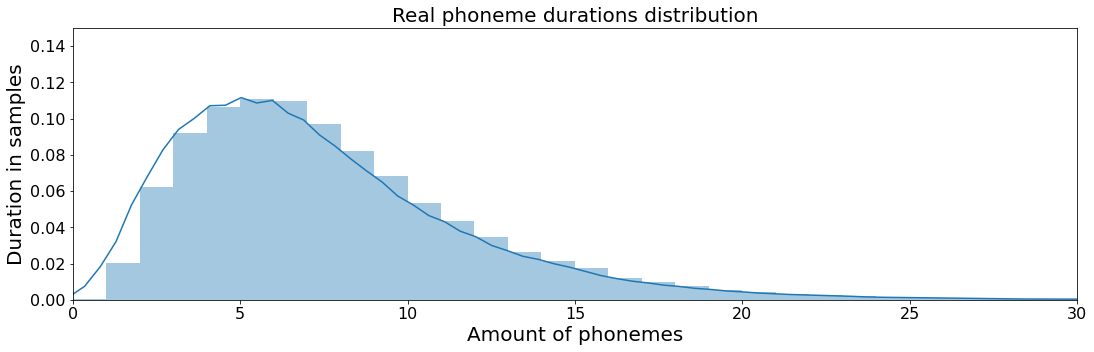

In [11]:
plt.figure(figsize=(18,5))
plt.title('Real phoneme durations distribution', fontsize=20)
sns.distplot(data,bins = 90)
plt.xlim(0,30)
plt.ylim(0,0.15)
plt.xlabel('Amount of phonemes', fontsize=20)
plt.ylabel('Duration in samples', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### Detected phoneme durations distribution

/home/stas/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

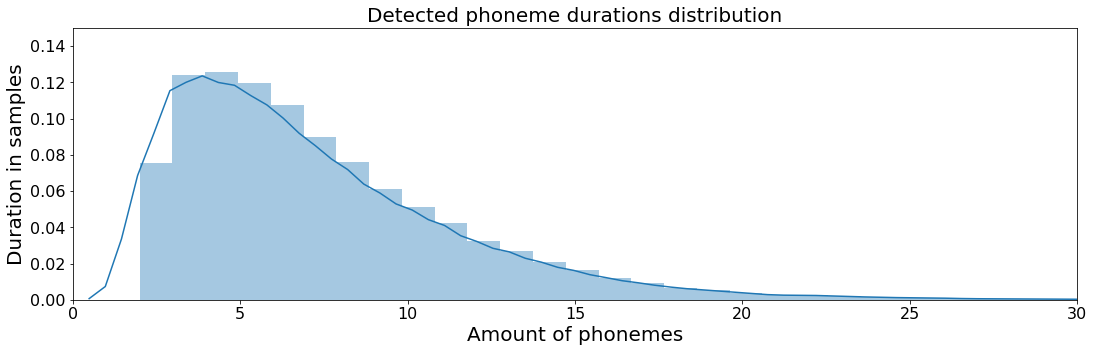

In [12]:
plt.figure(figsize=(18,5))
sns.distplot(data1,bins = 95)
plt.xlim(0,30)
plt.ylim(0,0.15)
plt.title('Detected phoneme durations distribution', fontsize=20)
plt.xlabel('Amount of phonemes', fontsize=20)
plt.ylabel('Duration in samples', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Consider too short and too long phonemes as outliers

In [14]:
# delete outliers using duration threshold
def outlier_detector(input_list, min_th, max_th):
    print('Input elements = ', len(input_list))
    out = []
    for item in input_list:
        if (item.shape[1] > min_th) and (item.shape[1] < max_th):
            out.append(item)
    print('Out elements = ', len(out))
    return out

phonemes_clean = outlier_detector(phonema_sliced, 2, 25)

Input elements =  64746
Out elements =  59568


In [15]:
# sum up along time axis to get appropriate format for clasterization
def sum_along_axis(phonemes_clean):
    print('Input elements = ', len(phonemes_clean))
    out = []
    for item in phonemes_clean:
        out.append(item.sum(axis = 1).reshape(64,1))
    print('Out elements = ', len(out))
    print('Out elements shape ', out[0].shape)
    return out

phonemes_clean_reprocessed = sum_along_axis(phonemes_clean)

Input elements =  59568
Out elements =  59568
Out elements shape  (64, 1)
